In [53]:
import tensorflow as tf 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
# Model improvement and Evaluation 
from sklearn import metrics 
from sklearn.metrics import confusion_matrix

print('tensorflow version', tf.__version__)
bank_data = pd.read_csv('data/1_american_dataset.csv')

# data_features = pd.read_csv('data/bankrupt_features.csv')
# data_status = pd.read_csv('data/status_bankrupt.csv')

tensorflow version 2.11.0


In [54]:
bank_data['status'].value_counts()

0    73462
1     5220
Name: status, dtype: int64

In [55]:
neg, pos = np.bincount(bank_data['status'])
total = neg + pos
print('Sample distributions:\n    Total: {}\n    Not Bankrupt (0): {} ({:.2f}% of total)\n    Bankrupt (1): {} ({:.2f}% of total)'.format(
    total, neg, (100 * neg) / total, pos, (100 * pos) / total))

Sample distributions:
    Total: 78682
    Not Bankrupt (0): 73462 (93.37% of total)
    Bankrupt (1): 5220 (6.63% of total)


## Remove entries from the majority class to balance the data.

In [56]:
indices = bank_data[bank_data['status'] == 0].index
random_indices = np.random.choice(indices, size=neg-pos, replace=False)
bank_balanced = bank_data.drop(random_indices)

counts = bank_balanced['status'].value_counts()
print(counts)

0    5220
1    5220
Name: status, dtype: int64


In [57]:
from sklearn.model_selection import train_test_split

numerical_only = bank_balanced.select_dtypes(include=['float64','int64'])
X = numerical_only.drop(['cik', 'fyear', 'status'], axis=1)
y = numerical_only['status']

In [44]:
# normalizer = tf.keras.layers.Normalization(axis=-1)
# normalizer.adapt(X)
# normalizer(X)

<tf.Tensor: shape=(10440, 18), dtype=float32, numpy=
array([[-0.08831016, -0.16695756, -0.11717075, ..., -0.1743905 ,
        -0.14181583, -0.12867276],
       [ 0.19978449, -0.07981596, -0.08360624, ..., -0.07065127,
        -0.06860308, -0.05863809],
       [-0.24646477, -0.2420315 , -0.20716344, ..., -0.23623824,
        -0.21981664, -0.21342848],
       ...,
       [-0.1337317 , -0.2032262 , -0.15729237, ..., -0.21909295,
        -0.17382284, -0.16006272],
       [-0.22250304, -0.23418091, -0.14126202, ..., -0.22863969,
        -0.17805517, -0.14649975],
       [-0.21541864, -0.06312932, -0.19676632, ..., -0.12302953,
        -0.20113291, -0.20217147]], dtype=float32)>

In [58]:
# split data into training (60%), validation (20%), and testing (20%) sets 
X_, X_test, y_, y_test = train_test_split(X, y, train_size=0.8, test_size=0.15, random_state=42, shuffle=True)
X_train, X_validate, y_train, y_validate = train_test_split(X_, y_, train_size=0.82, test_size=0.18, random_state=42, shuffle=True)

In [59]:
print("y_train data distribution:\n", y_train.value_counts())
print("y_validate data distribution:\n", y_validate.value_counts())
print("y_test data distribution:\n", y_validate.value_counts())

input_shape = (X.shape[1],)

y_train data distribution:
 0    3483
1    3365
Name: status, dtype: int64
y_validate data distribution:
 1    762
0    742
Name: status, dtype: int64
y_test data distribution:
 1    762
0    742
Name: status, dtype: int64


In [66]:
def bankruptcy_model():
    model = tf.keras.Sequential([
        # tf.keras.layers.Dense(32, activation='relu', input_shape=input_shape),
        tf.keras.layers.Dense(18, activation='relu', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(9, activation='relu', input_shape=input_shape),
        # tf.keras.layers.Dense(4, activation='relu', input_shape=input_shape),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])
    
    model.compile(optimizer='adam', 
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
            metrics=['accuracy'])
    return model

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=6, monitor='val_loss'),
    # tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    # tf.keras.callbacks.ModelCheckpoint(filepath='./best_model.h5', monitor='val_loss', save_best_only=True)
]

In [67]:
# adjusted learning rate
model_over = bankruptcy_model()
history = model_over.fit(X_train, y_train,
                    validation_data=(X_validate, y_validate),
                    epochs=100,
                    batch_size=25,
                    # callbacks=callbacks,
                    # class_weight=class_weight
                    )

Epoch 1/100
274/274 [==============================] - 2s 3ms/step - loss: 0.7285 - accuracy: 0.5147 - val_loss: 0.6970 - val_accuracy: 0.4940
Epoch 2/100
274/274 [==============================] - 1s 2ms/step - loss: 0.6790 - accuracy: 0.5578 - val_loss: 0.6891 - val_accuracy: 0.5066
Epoch 3/100
274/274 [==============================] - 1s 2ms/step - loss: 0.6633 - accuracy: 0.5853 - val_loss: 0.6853 - val_accuracy: 0.5153
Epoch 4/100
274/274 [==============================] - 1s 2ms/step - loss: 0.6541 - accuracy: 0.6035 - val_loss: 0.6842 - val_accuracy: 0.5372
Epoch 5/100
274/274 [==============================] - 1s 2ms/step - loss: 0.6525 - accuracy: 0.6047 - val_loss: 0.6784 - val_accuracy: 0.5472
Epoch 6/100
274/274 [==============================] - 1s 2ms/step - loss: 0.6476 - accuracy: 0.6075 - val_loss: 0.6787 - val_accuracy: 0.5445
Epoch 7/100
274/274 [==============================] - 1s 2ms/step - loss: 0.6508 - accuracy: 0.6046 - val_loss: 0.6728 - val_accuracy: 0.5552

In [19]:
def plot_history(history):
    fig, axs = plt.subplots(2, 1, figsize=(12, 8))

    # Plot training & validation accuracy values
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('Model accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Training Set', 'Validation Set'], loc='upper left')

    # Plot training & validation loss values
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Model loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Training Set', 'Validation Set'], loc='upper left')

    plt.show()

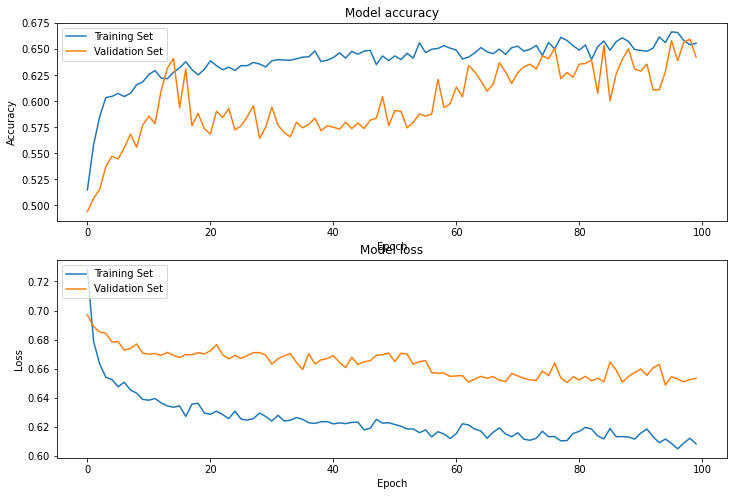

In [68]:
plot_history(history)